# Classificazione: modelli avanzati

Nel *notebook* precedente abbiamo discusso le basi del problema di classificazione, ed in particolare abbiamo preso come esempio la regressione logistica in cui la relazione tra la probabilità e le variabili di input è lineare, a meno di una funzione di attivazione. 

In questo *notebook* studieremo algoritmi più avanzati per descrivere la variazione della probabilità in funzione delle variabili di input, ed in particolare accenneremo a:
 * Decision Tree
 * Boosted Decision Trees
 * Neural Network
 * Modelli parametrici 

## No Free Lunch Theorem
Un modello è una versione semplificata delle osservazioni con il quale è addestrato. Le semplificazioni vanno intese come un tentativo di scartare i dettagli superflui che è improbabile si generalizzino a nuove osservazioni. Tuttavia, per decidere cosa scartare e cosa tenere nella costruzione del modello sono indispensabili delle assunzioni o delle ipotesi. Ad esempio, un modello di regressione lineare è basato sull'ipotesi che la relazione tra le variabili indipendenti e la variabile dipendente sia sostanzialmente lineare e che la deviazione delle osservazioni dal valore predetto è semplicemente un rumore che può essere tranquillamente ignorato. 

In un articolo del 1996, David Wolpert ha dimostrato che senza nessuna assunzione sulla natura dei dati, allora non c'è nessuna ragione per preferire un modello ad un altro. Questa considerazione va sotto il nome di **No Free Lunch Theorem** e rappresenta un caposaldo del machine-learning.

Per alcuni campioni di dati il modello migliore può essere un modello lineare, mentre per altri può essere una rete neurale, ma *a priori* non esiste garanzia che uno funzioni meglio dell'altro. 

Certo, dato un campione di dati si potrebbe provarli tutti e scegliere il migliore, ma nella pratica questo non è fattibile ed è quindi importante avere una percezione di quali sono le ipotesi fondamentali che rendono ragionevole aspettarsi che un modello funzioni bene. Per esempio per un task semplice si può confrontare una regressione lineare con un Decision Tree, mentre per un task complesso può essere utile confrontare un Boosted Decision Tree con una o più architetture di reti neurali.

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

## Il campione di dati

Per confrontare diversi modelli di classificazione e toccare con mano il significato del *No Free Lunch Theorem* utilizzermo un dataset complicato, ma con sole due variabili e due categorie di dati, diciamo 0 (blue) e 1 (rosso).
I due campioni sono distribuiti secondo due spirali adiacenti.

Punti rossi e punti blu sono facilmente separabili dall'occhio umano, ma per un algoritmo non è semplice indovinare quali sono le assunzioni da iniettare nella soluzione del problema per risolverlo in maniera generale.

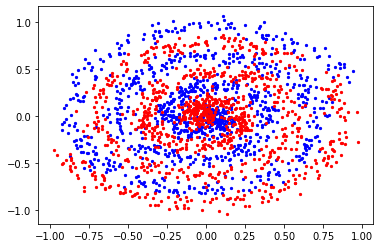

In [ ]:
f = 20
n0 = n1 = 1000

def generate_dataset (f=20, n0=1000, n1=1000):
  t0 = np.random.uniform(0, 1, n0)
  x0 = np.random.normal (t0 * np.sin(f*t0), 0.05)
  y0 = np.random.normal (t0 * np.cos(f*t0), 0.05)

  t1 = np.random.uniform(0, 1, n1)
  x1 = np.random.normal (t1 * np.sin(f*t1 + np.pi), 0.05)
  y1 = np.random.normal (t1 * np.cos(f*t1 + np.pi), 0.05)

  return x0, y0, x1, y1

x0, y0, x1, y1 = generate_dataset()

plt.scatter(x0, y0, s=5, color='blue')
plt.scatter(x1, y1, s=5, color='red')

## Modello lineare e polinomiale

Ovviamente, un modello lineare non è adeguato a risolvere questo problema.
Tuttavia possiamo usarlo per definire un termine di paragone.

In [ ]:
def make_plot(model=None, title=None):
  plt.scatter(x0, y0, s=5, color='blue', alpha=0.6)
  plt.scatter(x1, y1, s=5, color='red', alpha=0.6)
  plt.xlabel("x")
  plt.ylabel("y")
  if title is not None:
    plt.title(title)

  if model is not None:
    xAxis = np.linspace(-1,1,200)
    yAxis = np.linspace(-1,1,200)
    XY = np.array([(x_, y_) for x_ in xAxis for y_ in yAxis])
    chat = model.predict_proba(XY)[:,1].reshape((len(xAxis), len(yAxis)))
    #plt.contour(xAxis, yAxis, chat.T, cmap='seismic')
    plt.imshow(chat.T, extent = (-1,1,-1,1), cmap='seismic', alpha=0.4, origin='lower')
    plt.clim(-0.1,  1.1)


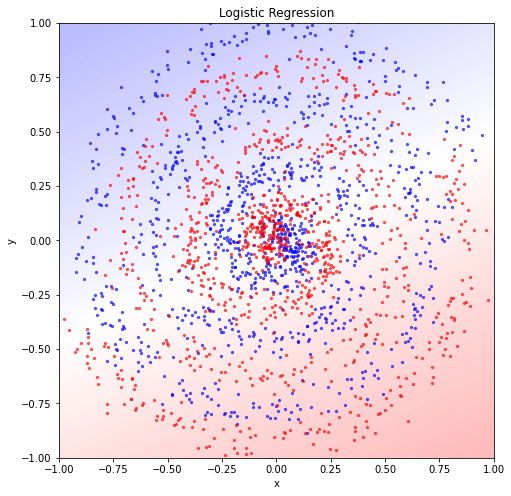

In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

poly = PolynomialFeatures(1)
method = LogisticRegression(penalty='none')
logistic_regression = Pipeline([('poly', poly), ('method', method)])

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(n0), np.ones(n1)))
logistic_regression.fit(X, c)
plt.figure(figsize=(8,8))
make_plot(logistic_regression, "Logistic Regression")

Anche preprocessando le variabili di input con la tecnica della regressione lineare, vista nello scorso *notebook*, non ci aspettiamo risultati particolarmente entusiasmanti.

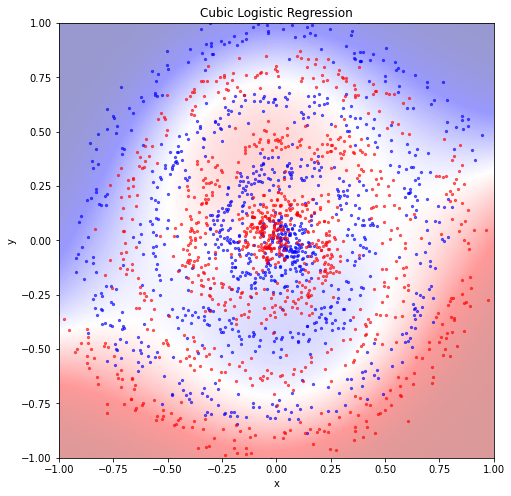

In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

poly = PolynomialFeatures(3)
method = LogisticRegression(penalty='none')
polynomial_logistic = Pipeline([('poly', poly), ('method', method)])

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(n0), np.ones(n1)))
polynomial_logistic.fit(X, c)
plt.figure(figsize=(8,8))
make_plot(polynomial_logistic, "Cubic Logistic Regression")

## ROC curve
È però utile definire una metrica per confrontare la performance di due algoritmi. In Fisica delle Alte Energie, tipicamente si sceglie di rappresentare la performance di un algoritmo di classificazione binaria con una *curva ROC* o *Receiver Operating Characteristic* (ROC) curve.   
Questi grafici sono costruiti ponendo sull'asse delle ascisse l'efficienza di selezione del segnale (*True Positive Rate*) e sull'asse delle ordinate la reiezione del fondo (*True Negative Rate*). 

Purtroppo, la definizione di curva ROC usata in Fisica delle Alte Energie è diversa da quella utilizzata altrove (ad esempio in scikit-learn) dove invece viene posto sull'asse delle ordinate l'efficienza di selezione del fondo (False Positive Rate). L'informazione che si trae dalle due curve è la stessa e in questo corso rimarremo fedeli alla convenzione usata in HEP. 

Per costruire la curva ROC utilizzeremo il modulo *metrics* di *scikit-learn*, e per semplicità definiremo una funzione `plot_roc` che si occupi di costruire il plot della curva ROC per un certo modello. 


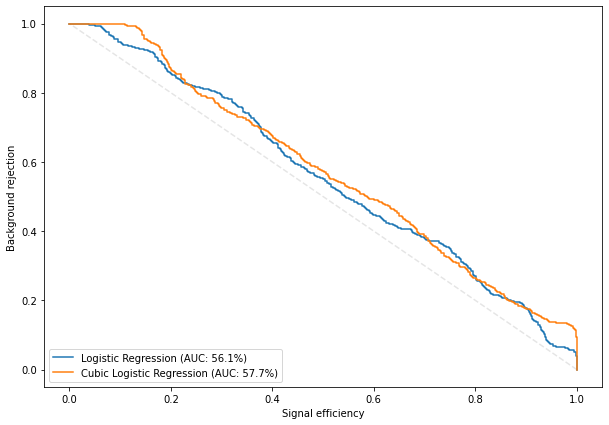

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score 

def plot_roc(X, c, model, title, fmt=''):
  chat_lr = model.predict_proba(X)[:,1]
  fpr, tpr, thresholds = roc_curve(c, chat_lr)
  plt.plot(tpr, 1-fpr, fmt, label=f"{title} (AUC: {100*roc_auc_score(c,chat_lr):.1f}%)")


plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, logistic_regression, "Logistic Regression")
plot_roc(X, c, polynomial_logistic, "Cubic Logistic Regression")

plt.legend(loc='lower left')

plt.show()

### Interpretazione della curva ROC, e AUC
Per interpretare il plot della curva ROC dobbiamo innanzitutto considerare che un algoritmo che selezioni completamente a caso gli eventi di segnale e gli eventi di fondo si porrà una linea retta che congiunge il punto (0,1) con il punto (1,0). 
In altre parole, noi possiamo scegliere di selezionare in modo del tutto casuale una frazione $f$ del campione di dati, e statisticamente selezioneremo una frazione $f$ del campione di segnale e rigetteremo una frazione $1-f$ del campione di fondo. Poiché il valore di $f$ può essere scelto arbitrariamente, il *punto di lavoro* del nostro algoritmo di selezione causale può variare lungo questa curva ROC rettilinea. 

Qualunque algoritmo presenterà due punti di lavoro estremali che corrispondono a prendere tutto il campione come segnale (efficienza 100%, reiezione 0%) o scartare tutto il campione come fondo (efficienza 0%, reiezione 100%). Quindi le curve ROC di tutti gli algoritmi passeranno per i punti (0,1) e (1,0). 

Detto ciò, l'algoritmo ideale permetterebbe di selezionare il 100% del segnale, rigettando il 100% del background, offrendo un punto di lavoro corrispondente al punto (1,1). 

Un algoritmo di selezione migliore di un algoritmo a selezione casuale, ma meno performante di un algoritmo ideale presenterà una curva ROC intermedia tra i due casi descritti. 

L'algoritmo di regressione logistica, anche nella sua espansione polinomiale, presenta curve ROC che sono molto vicine alla retta di selezione casuale, suggerendo che il potere discriminante di questi algoritmi su questo campione non sia eccellente. 

Per quantificare in un singolo numero la performance di un algoritmo di selezione binaria, si utilizza solitamente l'*area under the curve* (AUC), cioè l'integrale della curva ROC. 
Un valore di AUC del 50% indica che l'algoritmo effettua una selezione casuale di segnale e fondo, mentre un AUC del 100% indica un algoritmo in grado di fornire la completa separazione tra segnale e fondo.

Si noti che non è detto che esista un algoritmo in grado di separare perfettamente campioni di segnale e di fondo. Se le *pdf* generatrici dei campioni di segnale e fondo sono sovrapposte, un buon algoritmo *non può* riuscire a separare il segnale dal fondo, se non basandosi su fluttuazioni statistiche che non generalizzerano a campioni di dati statisticamente indipendenti.

Confrontando l'AUC della regressione logistica pura e semplice con quella della regressione logistica polonomiale vediamo che aggiungere ordini superiori permette di guadagnare qualche punto percentuale, ma rimaniamo molto lontani da una separazione ideale.

## Alberi decisionali (o *decision trees*)
Uno degli algoritmi più semplici e diffusi per affrontare il problema della classificazione binaria è il *decision tree*. 
Un albero decisionale è una sequenza di criteri di selezione in una struttura ad albero che partiziona lo spazio dei parametri cercando di individuare le regioni in cui l'una o l'altra categoria siano le più pure possibili. 

Gli alberi decisionali vengono fatti crescere dalla radice (*root*) verso le foglie (*leaves*) cercando di ottimizzare, ad ogni taglio successivo, la *binary cross-entropy*, oppure una sua approssimazione chiamata indice di Gini, che è leggermente più veloce.
Il numero di criteri di selezione applicati in sequenza prende il nome di *profondità* dell'albero decisionale.

Nel tentativo di visualizzare come viene fatto crescere un albero decisionale, addestriamo sei alberi decisionali con profondità massima crescente e confrontiamo le partizioni dello spazio ottenute.


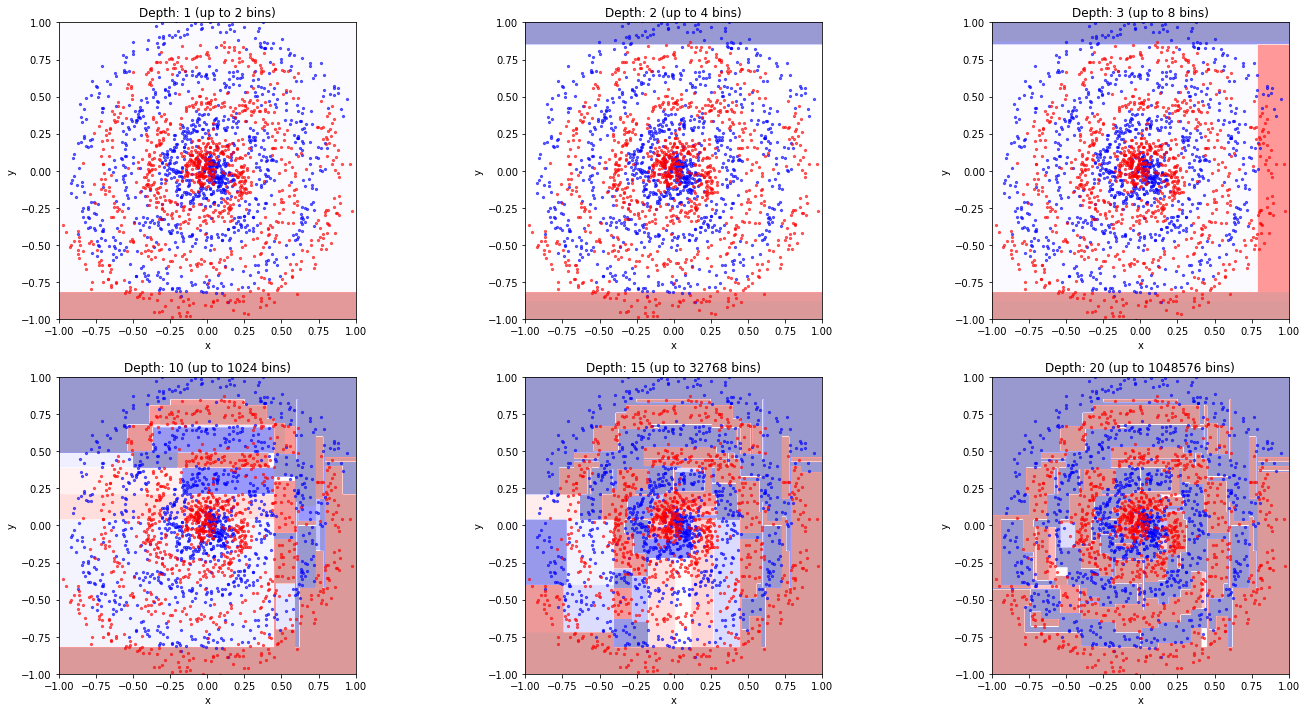

In [ ]:
from sklearn.tree import DecisionTreeClassifier as Dt
plt.figure(figsize=(20,10))
for iPlot, depth in enumerate([1, 2, 3, 10, 15, 20], 1):
  plt.subplot(2,3, iPlot)

  ## Istanziamo il decision tree
  dt = Dt(max_depth=depth)
  X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
  c = np.concatenate((np.zeros(n0), np.ones(n1)))

  ## Addestriamo il DT
  dt.fit(X, c)
  make_plot(dt, "Decision Tree")
  plt.title(f"Depth: {depth} (up to {2**depth} bins)")
plt.tight_layout()

Il dataset che abbiamo scelto è piuttosto difficile per gli alberi decisionali e per riuscire a districare segnale e fondo serve scendere a profondità importanti. Con una profondità pari a 20, corrispondente ad un numero di partizionamenti dello spazio dei parametri fino a $2^{20}$, vediamo che il *Decision Tree* riesce a separare in modo piuttosto accurato gli eventi di segnale e di fondo. Tuttavia, i bordi molto netti e alcune partizioni molto sottili ci dovrebbero trattenere dal credere che questo classficatore *generalizzi* altrettando bene ad un campione di dati diverso, seppure statisticamente equivalente a quello utilizzato per l'addestramento.

La curva ROC dell'albero decisionale costruita sul campione di addestramento mostra un potere discriminante davvero ottimo, con una AUC superiore al 99%. 
Aumentando ulteriormente la profondità massima, potremmo spingere il *decision tree* ad aderire ancora meglio al campione di dati di addestramento, arrivando ad AUC anche pari al 100%. Ma ha senso?

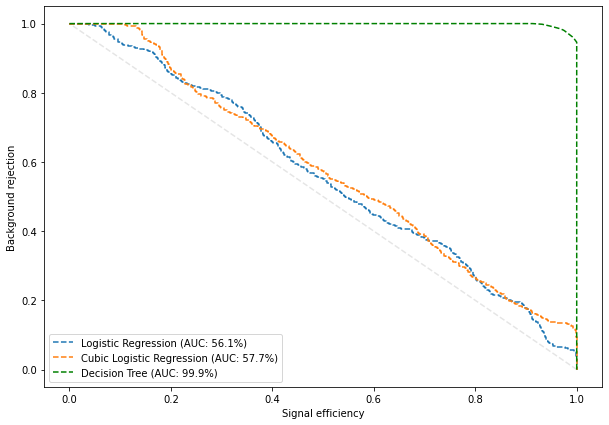

In [ ]:
plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, logistic_regression, "Logistic Regression", '--')
plot_roc(X, c, polynomial_logistic, "Cubic Logistic Regression", '--')
plot_roc(X, c, dt, "Decision Tree", 'g--')
plt.legend(loc='lower left')

plt.show()



### *Over-traininig* o *over-fitting* e validazione del modello 

Nel costruire un modello statistico, la domanda di quanto bene generalizza ad un campione di dati statisticamente equivalente a quello usato per l'addestramento è di importanza cruciale. Ricordiamo che del campione di addestramento conosciamo già le *label*, quindi separare perfettamente segnale e fondo non richiede alcun algoritmo, basta selezionare in base alle *label*. Il modello statistico ci serve se vogliamo classificare eventi statisticamente equivalenti a quelli usati nell'addestramento, ma privi di una label, ed è la *performance* dell'algoritmo su questi ultimi che, in ultima analisi, è rilevante. 

Quindi, una volta addestrato un algoritmo, è sempre una buona idea validarlo, ossia applicarlo ad un set di dati non utilizzato per l'addestramento ma del quale disponiamo delle *label*, e confrontare il risultato dell'algoritmo sul campione di addestramento e sul campione di validazione. 
Se le due *performance* non sono troppo diverse possiamo concludere che l'algoritmo *generalizza* bene da un campione all'altro. 
Viceversa, se la *performance* sul campione di validazione è molto peggiore di quella ottenuta sul campione di *addestramento*, significa che il modello addestrato non generalizza, o generalizza male. Intuitivamente possiamo immaginare che l'algortmo stia memorizzando gli elementi del campione di addestramento uno ad uno, in modo da separarli perfettamente tra segnale e fondo, senza preoccuparsi di definire delle regole applicabili ad campioni equivalenti.

Vediamo come si comporta il nostro albero decisionale addestrato con `max_depth=20` su un campione statisticamente equivalente a quello di addestramento confrontando le curve ROC.

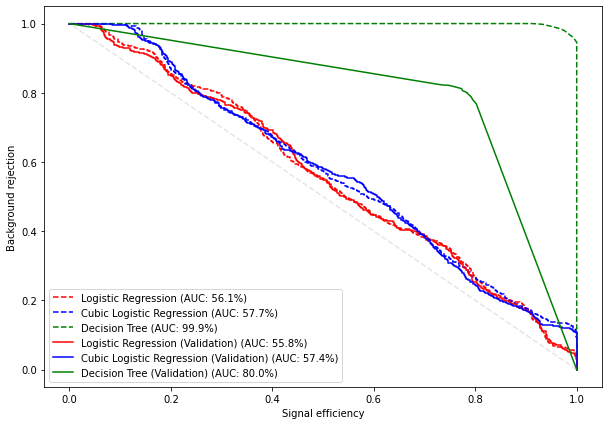

In [ ]:
plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, logistic_regression, "Logistic Regression", 'r--')
plot_roc(X, c, polynomial_logistic, "Cubic Logistic Regression", 'b--')
plot_roc(X, c, dt, "Decision Tree", 'g--')

# Validation sample
vx0, vy0, vx1, vy1 = generate_dataset()
vX = np.concatenate((np.c_[vx0,vy0], np.c_[vx1,vy1]))
vc = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

plot_roc(vX, vc, logistic_regression, "Logistic Regression (Validation)", 'r-')
plot_roc(vX, vc, polynomial_logistic, "Cubic Logistic Regression (Validation)", 'b-')
plot_roc(vX, vc, dt, "Decision Tree (Validation)", 'g-')

plt.legend(loc='lower left')
plt.show()

Osserviamo che la *performance* sul campione di validazione di riduce drasticamente, con un'AUC intorno all'80%. 
Questo effetto di ridotta generalizzazione prende il nome di *over-training* o *over-fitting*.

Ora, nonostante ci sia evidentemente un effetto importante di *over-training* nel nostro BDT, sarebbe preferibile usare il BDT rispetto ad una regressione logistica. Infatti, anche se innegabilmente in over-training, il BDT mostra una *performance* migliore rispetto alla regressione logistica che pure generalizza bene. 
Il punto, però, è che il nostro BDT potrebbe funzionare meglio di così sul campione di validazione se ne riducessimo la complessità, ad esempio riducendo la `max_depth`. In questo esempio, la AUC sul campione di validazione del BDT è più alta con una profondità massima di 15 rispetto a quella ottenuta con una di 20. 

In sintesi, quindi, va ricordato che la metrica ottenuta sul campione di addestramento è inaffidabile e deve essere confrontata con la metrica ottenuta sul campione di validazione. 

### Contrastare l'*over-training*.
Per migliorare la capacità del modello costruito di generalizzare a campioni mai visti prima possiamo adottare alcune strategie:
 * aumentare la statistica del campione di addestramento: se possibile, aumentare il numero di elementi nel campione di addestramento permette di ottenere modelli statistici più vicini alla funzione generatrice delle distribuzioni.
 * ridurre la complessità del modello: se non è possibile o è troppo costoso aumentare la statistica del campione di addestramento, possiamo cercare di ridurre la complessità del modello. Ad esempio possiamo ridurre il numero di variabili di input, oppure, nel caso di un albero decisionale, possiamo ridurrne la profondità, in questo modo rendiamo il modello meno potente e quindi meno sensibile a fluttuazioni statistiche che non rappresentano caratteristiche della funzione generatrice.
 * regolarizzare il modello: se rendere meno complesso il modello non è possibile, possiamo anche aggiungere regole aggiuntive che rendano più difficle per il modello imparare le fluttuazioni statistiche. Ad esempio nel caso di un albero decisionale, possiamo imporre nessuna foglia possa contenere meno di un certo numero di eventi. In questo modo lasciamo libero il decision tree di crescere quanto necessario nelle regioni dove c'è elevata statistica, impedendogli però di andare in over-fitting dove la statistica è limitata. 


Nell'esempio sotto, mostriamo l'effetto della regolarizzazione sull'albero decisionale discusso in precedenza.

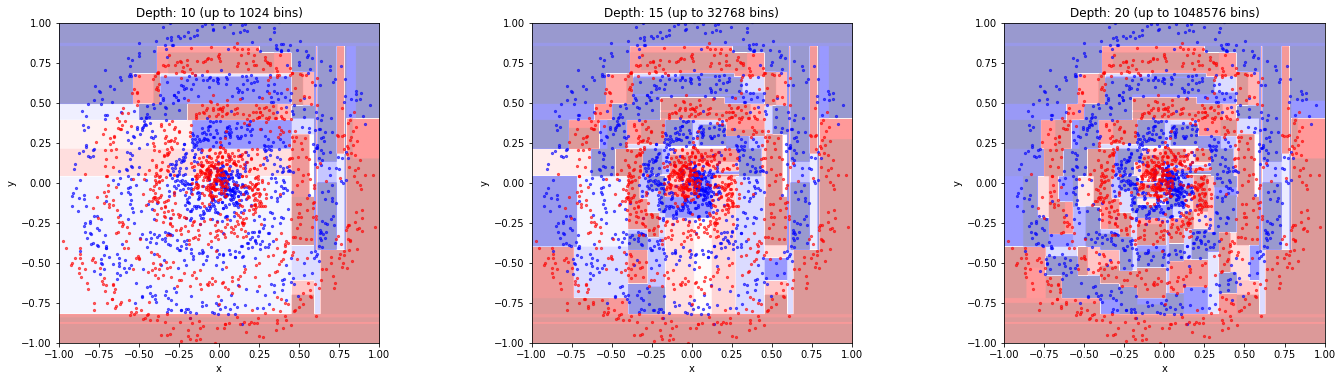

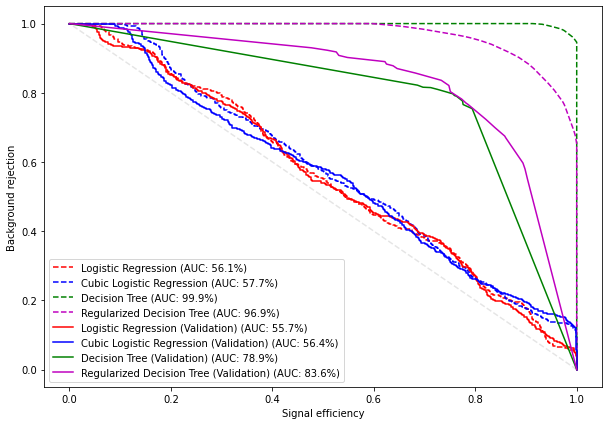

In [ ]:
from sklearn.tree import DecisionTreeClassifier as Dt
plt.figure(figsize=(20,10))

for iPlot, depth in enumerate([10, 15, 20], 1):
  plt.subplot(2,3, iPlot)

  ## Istanziamo il decision tree
  rdt = Dt(max_depth=depth, min_samples_leaf=5)
  X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
  c = np.concatenate((np.zeros(n0), np.ones(n1)))

  ## Addestriamo il DT
  rdt.fit(X, c)
  make_plot(rdt, "Decision Tree")
  plt.title(f"Depth: {depth} (up to {2**depth} bins)")
plt.tight_layout()

plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, logistic_regression, "Logistic Regression", 'r--')
plot_roc(X, c, polynomial_logistic, "Cubic Logistic Regression", 'b--')
plot_roc(X, c, dt, "Decision Tree", 'g--')
plot_roc(X, c, rdt, "Regularized Decision Tree", 'm--')

# Validation sample
vx0, vy0, vx1, vy1 = generate_dataset()
vX = np.concatenate((np.c_[vx0,vy0], np.c_[vx1,vy1]))
vc = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

plot_roc(vX, vc, logistic_regression, "Logistic Regression (Validation)", 'r-')
plot_roc(vX, vc, polynomial_logistic, "Cubic Logistic Regression (Validation)", 'b-')
plot_roc(vX, vc, dt, "Decision Tree (Validation)", 'g-')
plot_roc(vX, vc, rdt, "Regularized Decision Tree (Validation)", 'm-')

plt.legend(loc='lower left')
plt.show()

## *Ensemble learning* e *Decision forest*
Una tecnica molto diffusa per costruire modelli complessi basati su algoritmi semplici (come ad esempio un albero decisionale) è quella di addestrare tanti algoritmi a priori equvalenti e combiniarli tra loro, ad esempio prendendo la media delle predizioni ottenute da ciascuno, o implemtnando un sistema di *votazione* in cui si prende per buona la predizione ottenuta dalla maggioranza degli algoritmi. 

Queta tecnica chiamata *ensemble learning* o talvolta *meta learning* è valida ed applicabile per svariati algoritmi, ma è molto diffusa in particolare per gli alberi decisionali. 
Combinando molti alberi decisionali, fatti crescere con una profondità piccola, e su una selezione casuale del campione di addestramento è possibile ottenere predizioni che generalizzano piuttosto bene con algoritmi altamente parallelizzabili e intrinsecamente molto semplici. 

Questi algorimi vengono indicati spesso come *Random Forest* e sono importanti perché, seppure non terribilmente potenti, hanno pochi *iper-parametri* e funzionano decentemente su un gran numero di problemi. 
Per questa ragione, spesso la prima cosa che si fa di fronte ad un problema di classificazione è addestrare una Random Forest e usarla come termine di paragone nel tentativo di ottenere dei miglioramenti.

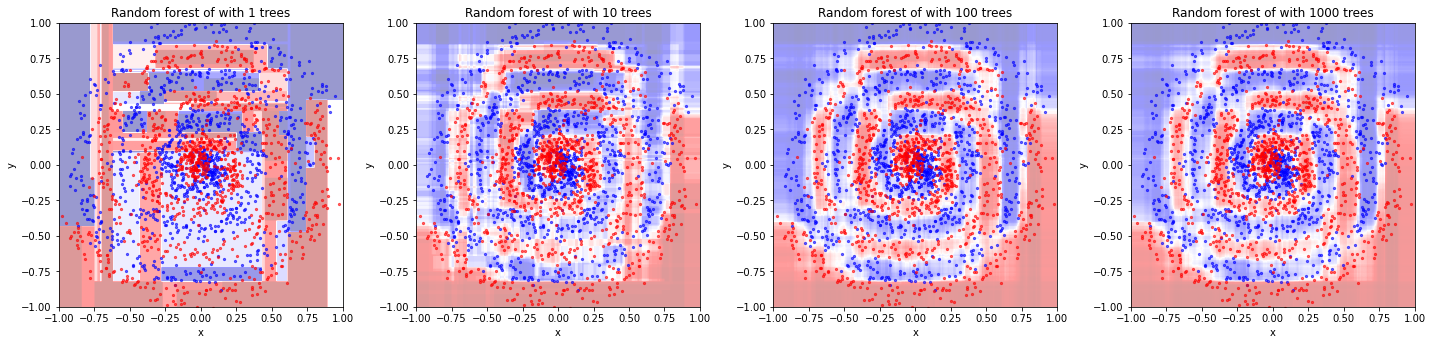

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RF
plt.figure(figsize=(20,10))

for iPlot, n_estimators in enumerate([1, 10, 100, 1000], 1):
  rf = RF(n_estimators=n_estimators, max_depth=15, min_samples_leaf=4, max_samples=0.8)
  X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
  c = np.concatenate((np.zeros(n0), np.ones(n1)))
  rf.fit(X, c)
  plt.subplot(1,4,iPlot)
  make_plot(rf, f"Random forest of with {n_estimators} trees")
plt.tight_layout()

### Boosted Decision Trees 

Il principale pregio delle *Random Forest* è anche la maggiore limitazione:  ogni albero è fatto crescere indipendentemente dagli altri. Questa caratteristica rende difficile correggere la procedura di training per tenere in maggiore considerazione gli eventi rari, anche se raggruppati in una regione specifica dello spazio dei parametri. 
Per questa ragione, sono stati sviluppati i *Boosted Decision Tree* che sono degli algoritmi di *ensemble learning* composti da più *Decision Tree* in cui però gli alberi decisionali vengono addestrati in sequenza, cercando, con ogni nuovo albero, di mitigare gli errori commessi dai decision tree precedenti. 
Due algoritmi di *boosting* sono particolarmente diffusi:
 * **AdaBoost** che consiste nell'assegnare un peso maggiore a agli eventi. identificati male allo step precedente;
 * **Gradient Boosting** che consiste nel cercare di prevedere, per ciascuna combinazione dello spazio dei parametri il contributo alla bniary-crossentropy fino allo step precedente, correggendo di conseguenza. 

Riferimenti utili per approfondire questi algoritmi sono:
 * [La guida di scikit-learn](https://scikit-learn.org/stable/modules/ensemble.html)
 * [Una lezione sui BDT preparata per un altro corso](https://colab.research.google.com/drive/18NHWmORaYDtpQq74mKJwTb97UZ1R2w0w?usp=sharing)

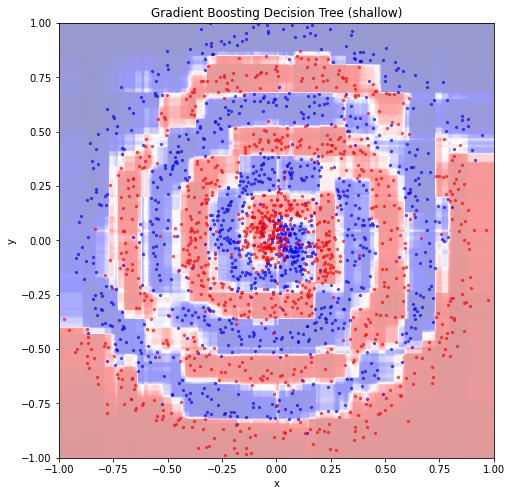

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier as Gbdt

bdt = Gbdt(n_estimators=60, max_depth=10, min_samples_leaf=10)
X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(n0), np.ones(n1)))
bdt.fit(X, c)
plt.figure(figsize=(8,8))
make_plot(bdt, "Gradient Boosting Decision Tree (shallow)")

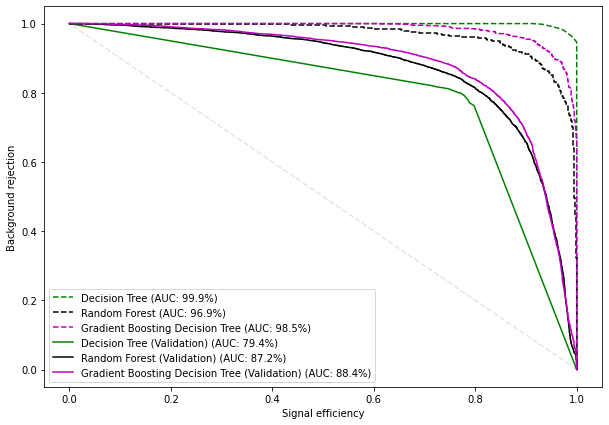

In [ ]:
plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, dt, "Decision Tree", 'g--')
plot_roc(X, c, rf, "Random Forest", 'k--')
plot_roc(X, c, bdt, "Gradient Boosting Decision Tree", 'm--')

# Validation sample
vx0, vy0, vx1, vy1 = generate_dataset(n0=10000, n1=10000)
vX = np.concatenate((np.c_[vx0,vy0], np.c_[vx1,vy1]))
vc = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

plot_roc(vX, vc, dt, "Decision Tree (Validation)", 'g-')
plot_roc(vX, vc, rf, "Random Forest (Validation)", 'k-')
plot_roc(vX, vc, bdt, "Gradient Boosting Decision Tree (Validation)", 'm-')


plt.legend(loc='lower left')

plt.show()


Dal confronto delle *performance* di Decision Tree, Random Forests e Gradient Boosted Decision Tree osserviamo su questo dataset particolarmente difficle, osserviamo che tutti e tre sono decisamente in over-training, ma che si ottengono comunque valori di AUC tra 80 e 90% sul campione di validazione, che non è malissimo, ma non è neppure necessariamente ottimale.

Sicuramente, ripensando al *No Free Lunch Theorem* possiamo notare come le assunzioni che stanno alla base della costruzione di un *decision tree* sono piuttosto diverse da quelle che caratterizzano il dataset che stiamo considerando. 

Infatti nel campione che stiamo studiando:
 * la separazione tra le categorie non è netta, ma (per costruzione) le pdf si sovrappongono, 
 * le regioni ad equi-probabilità non sono parallele agli assi, ma strutturate in modo più o meno circolare

Consideriamo allora altri algoritmi.

## Reti Neurali Artificiali (*Artificial Neural Networks*, ANN)

Il primo tentativo che abbiamo discusso per costruire un modello statistico per il nostro *dataset* spiraleggiante si basava sulla regressione logistica, che abbiamo poi provato a modificare aggiungendo variabili ottenute con **trasformazioni non lineari** delle variabili originali. 

Invece che utlizzare le potenze delle variabili di input in una sorta di regressione logistica polinomiale, potremmo cercare quelle trasformazioni non-lineari ottimali per poter poi separare le categorie che costituiscono il nostro *dataset*.

Per poter ottimizzare con algoritmi numerici queste trasformazioni non lineari, è importante che sia semplice calcolarne le derivate, ed in particolare il gradiente. Per semplificare il calcolo del gradiente scriveremo le trasformazioni seguendo queste regole:
 * le trasformazioni sono descritte con composizione di funzione: la derivata di una composizione di funzione è definita da una formula analitica (così detta *chain rule*)
 * le trasformazioni elementari possono essere di due tipi:
   * *element-wise*, cioè che agiscano nello stesso modo su ciascun elemento del vettore che prendono come *input*: in questo caso il calcolo del gradiente è semplicemente il calcolo della derivata della funzione rispetto a ciascun input indipendentemente dagli altri;
   * *lineare*, cioè esprimibile come applicazione lineare di tipo $\mathbf{A}\vec x + \vec b$: lo Jacobiano di queste operazioni è semplicemente $\mathbf A$. 

Una trasformazione di questo tipo può essere scritta nella forma
$$
\vec h = f(\mathbf A\vec x + \vec b) 
$$
dove 
 * $\vec h$ è la **rappresentazione** che passeremo poi come *input* alla regressione logistica,
 * $\vec x$ è il vettore delle variabili originali da trasformare
 * $\mathbf A$ e $\vec b$ sono parametri liberi da ottimizzare 

Possiamo completare la scrittura dell'algoritmo di classificazione esplicitando anche la parte relativa alla regressione logistica, scrivendo
$$
\hat y = \sigma \Big( w^{\mathrm T} f(\mathbf A\vec x + \vec b) + y_0\Big)
$$
dove:
 * $\sigma(\cdot)$ è la funzione sigmoide
 * $\hat y$ è la probabilità che un punto con coordinate $\vec x$ appartenga alla classe $1$
 * $w^\mathrm T$, $\mathbf A$, $\vec b$ e $y_0$ sono parametri liberi da ottimizzare con algoritmi di discesa del gradiente. 

Questa espressione definisce una semplice **Rete Neurale Artificiale** chiamata **Multi-Layer Perceptron** (MLP) Possiamo estendere il ragionamento applicando la rete MLP ad un vettore di variabili trasformate con una trasformazione non lineare ottimizzabile. Ciascuna di queste trasformazioni prenderà il nome di *layer* e aggiungendo *layer* alla *nerual network* la renderemo *profonda*, arrivando a definire una **Deep Neural Network**.

Le reti neurali più performanti si ottengono con librerie dedicate come *keras*, *tensorflow* o *pytorch*. Queste librerie differiscono da scikit-learn perché si basano su un re-implementazione dii tutte le operazioni algebriche e analitiche di numpy che consente di calcolare le derivate e i gradienti in modo quasi analitico, velocizzando drasticamente la fase di ottimizzazione di problemi a molti parametri. 

*scikit-learn* offre la sua implementazione che è adeguata per task semplici fino a qualche migliaia di parametri liberi. 

Vediamo un esempio di una rete MLP, con un singolo layer tra l'input e la rappresentazione (1 hidden layer) e quindi talvolta indicata come "shallow" neural network.

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


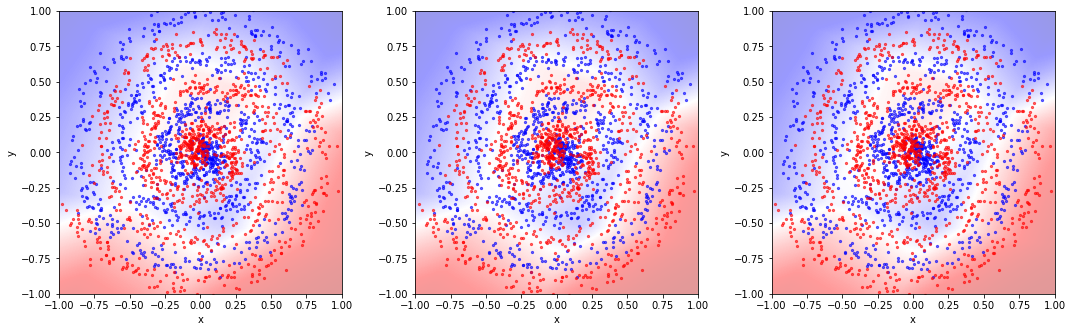

In [ ]:
from sklearn.neural_network import MLPClassifier as Ann

ann = Ann(activation='relu', hidden_layer_sizes=(128), warm_start=True)
X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(n0), np.ones(n1)))
plt.figure(figsize=(15,5))
for i in range(3):
  plt.subplot(1,3,i+1)
  ann.fit(X, c)
  make_plot(ann)

plt.tight_layout()

La differenza con il risultato ottenuto con i Decision Tree è evidente, e ricorda vagamente quanto ottenuto con la regressione polinomiale, che infatti è un algoritmo concettualmente simile (anche se molto più semplice).
Dal punto di vista delle *performance*, tuttavia, il risultato è piuttosto deludente se confrontato con un *Boosted Decision Tree*. 

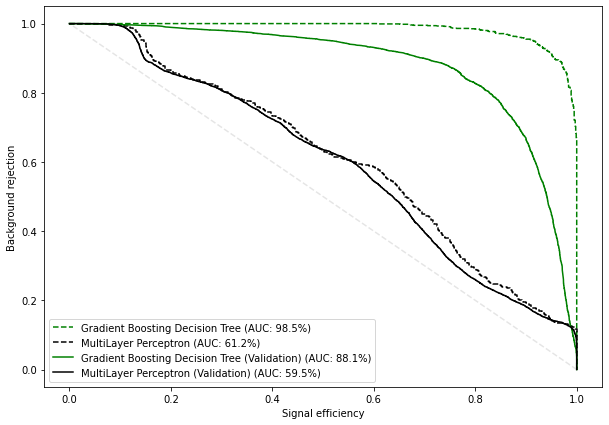

In [ ]:
plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, bdt, "Gradient Boosting Decision Tree", 'g--')
plot_roc(X, c, ann, "MultiLayer Perceptron", 'k--')

# Validation sample
vx0, vy0, vx1, vy1 = generate_dataset(n0=10000, n1=10000)
vX = np.concatenate((np.c_[vx0,vy0], np.c_[vx1,vy1]))
vc = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

plot_roc(vX, vc, bdt, "Gradient Boosting Decision Tree (Validation)", 'g-')
plot_roc(vX, vc, ann, "MultiLayer Perceptron (Validation)", 'k-')

plt.legend(loc='lower left')

plt.show()

Pretrasformando le variabili di input per dare accesso alla rete anche alla seconda e terza potenza delle variabili di input e aggiungendo un secondo layer le cose migliorano significativamente.

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


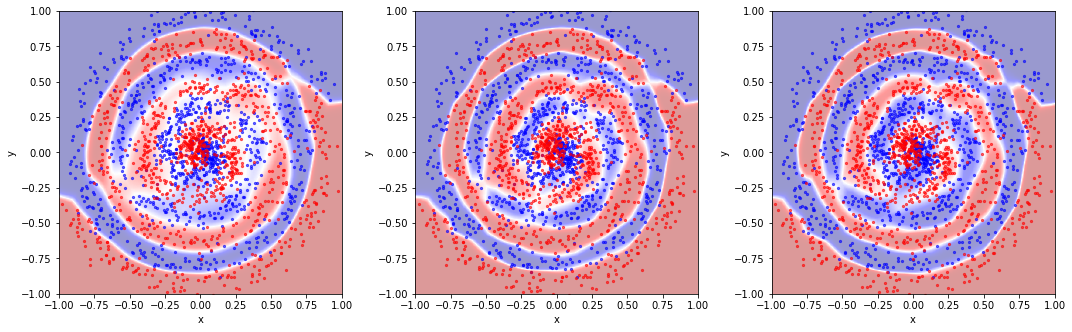

In [ ]:
poly = PolynomialFeatures(3)
method = Ann(activation='relu', hidden_layer_sizes=(128, 128), warm_start=True)
polyann = Pipeline([('poly', poly), ('method', method)])

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(n0), np.ones(n1)))
plt.figure(figsize=(15,5))
for i in range(3):
  plt.subplot(1,3,i+1)
  polyann.fit(X, c)
  make_plot(polyann)

plt.tight_layout()

Tuttavia vicino al centro dell'immagine, intorno al punto (0, 0) la rete fatica a sbrogliare le due categorie, segnale e fondo. Possiamo aiutare la rete preprocessando gli input trasformati, come nel caso della regressione polinomiale di ordine elevato.

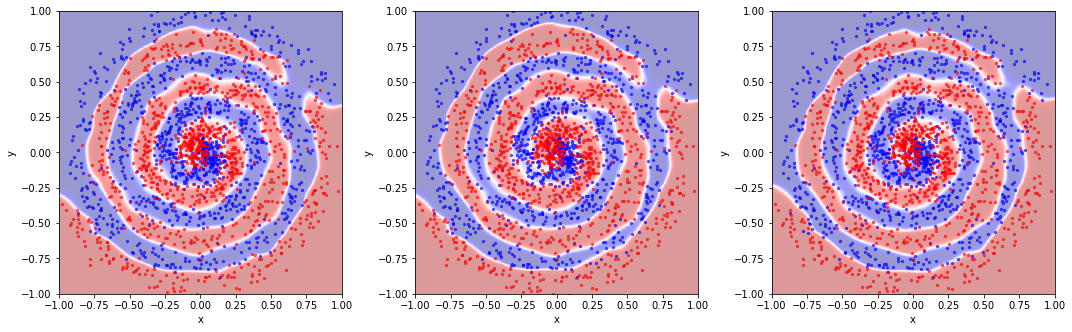

In [ ]:
from sklearn.preprocessing import StandardScaler

poly = PolynomialFeatures(3)
method = Ann(activation='relu', hidden_layer_sizes=(128, 128), warm_start=True)
scaled_polyann = Pipeline([('poly', poly), ('scaler', StandardScaler()), ('method', method)])

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(n0), np.ones(n1)))
plt.figure(figsize=(15,5))
for i in range(3):
  plt.subplot(1,3,i+1)
  scaled_polyann.fit(X, c)
  make_plot(scaled_polyann)

plt.tight_layout()

Dal confronto tra i vari algorimi, osserviamo che siamo riusciti a spingere la rete neurale a *performance* superiori rispetto a quelle del BDT, con un livello di *over-training* inferiore e tutto sommato accettabile.

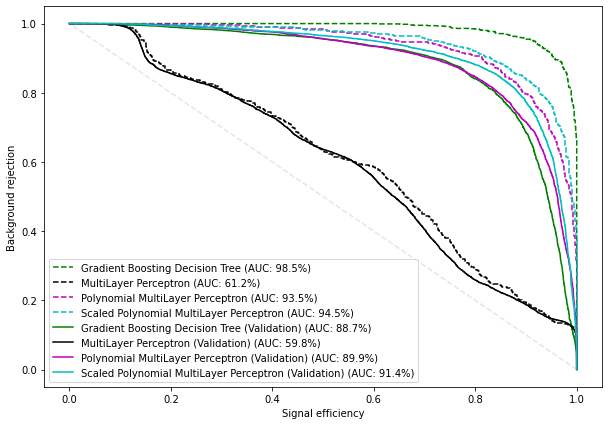

In [ ]:
plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, bdt, "Gradient Boosting Decision Tree", 'g--')
plot_roc(X, c, ann, "MultiLayer Perceptron", 'k--')
plot_roc(X, c, polyann, "Polynomial MultiLayer Perceptron", 'm--')
plot_roc(X, c, scaled_polyann, "Scaled Polynomial MultiLayer Perceptron", 'c--')



# Validation sample
vx0, vy0, vx1, vy1 = generate_dataset(n0=10000, n1=10000)
vX = np.concatenate((np.c_[vx0,vy0], np.c_[vx1,vy1]))
vc = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

plot_roc(vX, vc, bdt, "Gradient Boosting Decision Tree (Validation)", 'g-')
plot_roc(vX, vc, ann, "MultiLayer Perceptron (Validation)", 'k-')
plot_roc(vX, vc, polyann, "Polynomial MultiLayer Perceptron (Validation)", 'm-')
plot_roc(vX, vc, scaled_polyann, "Scaled Polynomial MultiLayer Perceptron (Validation)", 'c-')

plt.legend(loc='lower left')

plt.show()

## Capire il problema è meglio che andare a tentativi

BDT e Reti Neurali sono algoritmi potenti che consentono di ottenere risultati decorosi con poco sforzo e in condizioni in cui fare ipotesi sul dataset è obiettivamente difficile. 
Tuttavia, possiamo "aiutare" questi algoritmi avendo in mente quali assunzioni possiamo iniettare nella soluzione del problema secondo la nostra esperienza e creatività di esseri umani.

Ad esempio nel caso specifico di questo dataset, il nostro occhio umano e la nostra esperienza dopo i corsi di Fisica I e Fisica II ci dice che se dovessimo tentare di affrontare questo problema analiticamente, sarebbe più semplice provarci in coordinate polari. 

Il problema è esattamente lo stesso, ma stiamo predisponendo l'algoritmo di calssificazione per funzionare meglio per problemi in cui le curve di livello sono simili a circoferenze centrate nell'origine. 

Certo, una rete neurale sufficientemente profonda può imparare che questa rappresentazione è la più comoda per descrivere il problema. Tuttavia avrà bisogno di molti dati per convincersi, a priori, che una rappresentazione polare sia meglio di una rappresentazione, a performance equivalenti, che separa a zig-zag quasi perfettamente segnale e fondo.
Questo accade perchè *a priori*, la rappresentazione in coordinate polari non è una rappresentazione privilegiata. Tutto sommato, calcolare il raggio non è banale combinando operazioni lineari matriciali e operazioni non-lineari *element-wise*.

Per questo, laddove possiamo aiutare l'algoritmo a individuare una rappresentazione più adeguata alla soluzione del problema (che implica che stiamo facendo ipotesi sul dataset al quale applichiamo l'algoritmo) conviene farlo.

Il problema in coordinate polari diventa questo:


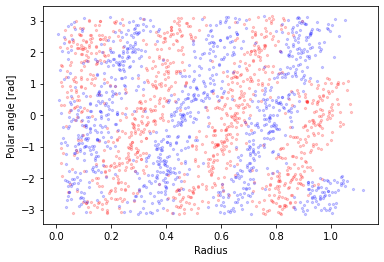

In [ ]:
from sklearn.preprocessing import FunctionTransformer
X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))

prep = FunctionTransformer(lambda x: np.c_[(x[:,0]**2 + x[:,1]**2)**0.5, np.arctan2(x[:,0], x[:,1])])

pX = prep.transform(X)
plt.scatter(pX[c==0,0], pX[c==0,1], color='red', s=5, alpha=0.2)
plt.scatter(pX[c==1,0], pX[c==1,1], color='blue', s=5, alpha=0.2)
plt.xlabel("Radius")
plt.ylabel("Polar angle [rad]")
plt.show()

Ancora non è ideale per un BDT, ma per una Neural Network diventa un problema quasi banale. Basta un singolo layer per funzionare bene quanto, o meglio di, un BDT con ottime proprietà di generalizzazione.

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


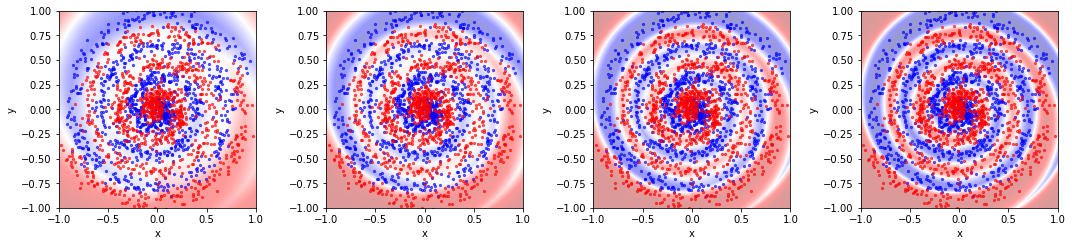

In [ ]:
from sklearn.preprocessing import StandardScaler
prep = FunctionTransformer(lambda x: np.c_[(x[:,0]**2 + x[:,1]**2)**0.5, np.arctan2(x[:,0], x[:,1])])
method = Ann(activation='relu', hidden_layer_sizes=(128), warm_start=True)
scaler = StandardScaler()
preprocessed_ann = Pipeline([('prep', prep), ('scaler', scaler), ('method', method)])

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
y = np.concatenate((np.zeros(n0), np.ones(n1)))
plt.figure(figsize=(15,5))

for i in range(4):
  plt.subplot(1,4,i+1)
  preprocessed_ann.fit(X, c)
  make_plot(preprocessed_ann)

plt.tight_layout()

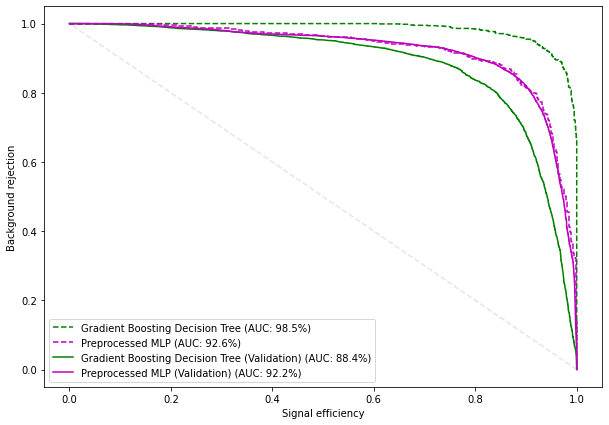

In [ ]:
plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, bdt, "Gradient Boosting Decision Tree", 'g--')
plot_roc(X, c, preprocessed_ann, "Preprocessed MLP", 'm--')


X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

# Validation sample
vx0, vy0, vx1, vy1 = generate_dataset(n0=10000, n1=10000)
vX = np.concatenate((np.c_[vx0,vy0], np.c_[vx1,vy1]))
vc = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

plot_roc(vX, vc, bdt, "Gradient Boosting Decision Tree (Validation)", 'g-')
plot_roc(vX, vc, preprocessed_ann, "Preprocessed MLP (Validation)", 'm-')


plt.legend(loc='lower left')

plt.show()

Per confronto, riportiamo anche il BDT ottenuto con variabili trasformate in coordinate polari. Migliora, ma meno della rete neurale.

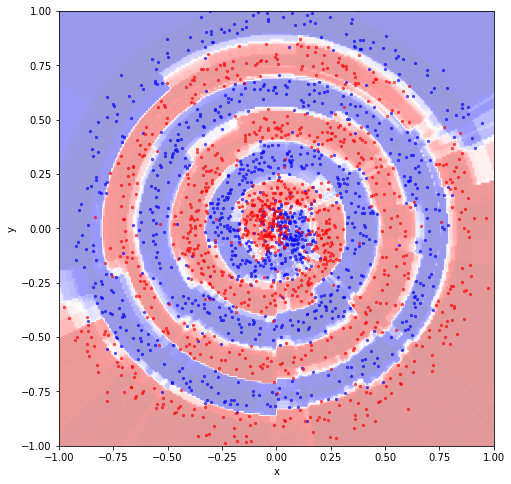

In [ ]:
from sklearn.preprocessing import StandardScaler
prep = FunctionTransformer(lambda x: np.c_[(x[:,0]**2 + x[:,1]**2)**0.5, np.arctan2(x[:,0], x[:,1])])
method = Gbdt(n_estimators=60, max_depth=10, min_samples_leaf=10)
scaler = StandardScaler()
preprocessed_bdt = Pipeline([('prep', prep), ('scaler', scaler), ('method', method)])

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
y = np.concatenate((np.zeros(n0), np.ones(n1)))
preprocessed_bdt.fit(X, y)

plt.figure(figsize=(8,8))
make_plot(preprocessed_bdt)
plt.show()

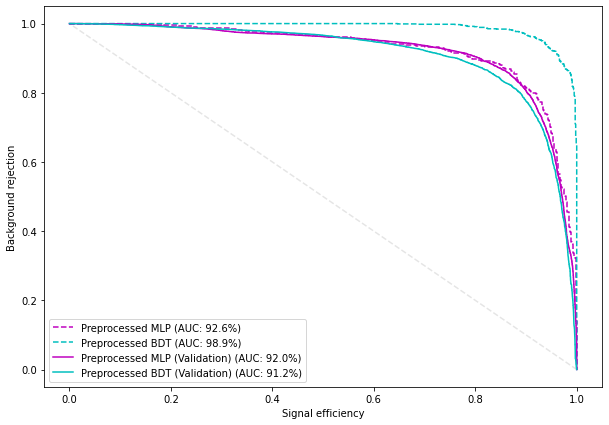

In [ ]:
plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, preprocessed_ann, "Preprocessed MLP", 'm--')
plot_roc(X, c, preprocessed_bdt, "Preprocessed BDT", 'c--')


X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

# Validation sample
vx0, vy0, vx1, vy1 = generate_dataset(n0=10000, n1=10000)
vX = np.concatenate((np.c_[vx0,vy0], np.c_[vx1,vy1]))
vc = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

plot_roc(vX, vc, preprocessed_ann, "Preprocessed MLP (Validation)", 'm-')
plot_roc(vX, vc, preprocessed_bdt, "Preprocessed BDT (Validation)", 'c-')


plt.legend(loc='lower left')

plt.show()

## Classificare con Minuit
Per concludere la discussione sui modelli di classificazione, consideriamo anche il caso estremo in cui conosciamo la forma parametrica delle distribuzioni generatrici dei dati che vogliamo classificare, e costruiamo un classificatore analitico, ottimizzato (ad esempio) con Minuit.

In questo caso non stiamo semplicemente modificando la rappresentazione dei dati in modo che la separazione possa essere bene approssimata da una relazione lineare, come fanno le reti neurali, ma costruiamo un modello massimamente specializzato al problema di classificazione che stiamo affrontando. 

Dal punto di vista del No Free Lunch Theorem, stiamo iniettando nel sistema il massimo della conoscenza di cui disponiamo sul dataset che vogliamo classificare, e ci aspettiamo quindi di ottenere un classificatore dalle performance eccellenti sia in termini di potere discriminante che in termini di generalizzazione.

Per poter confrontare agevolmente il modello così ottenuto con i modelli di `scikit-learn` definiti fin qui, costruiremo una classe che implementi i metodi `fit` e `predict_proba` secondo la stessa *signature* (cioè aspettandosi gli stessi argomenti in ingresso, nello stesso ordine e con gli stessi nomi) dei metodi implementati dalle classi di `scikit-learn`. Chiameremo questo modello `CustomModel`.

Per costruire un modello analitico di classificazione è utile partire dal [Lemma di Neyman-Pearson](https://en.wikipedia.org/wiki/Neyman%E2%80%93Pearson_lemma) secondo cui nei problemi di test d'ipotesi tra due ipotesi alternative $H_0$ e $H_1$, lo statistico di test più potente è il rapporto delle funzioni verosimiglianza,
$$
T = \frac{\mathcal L(H_0 | \vec x)}{\mathcal L(H_0 | \vec x)}
$$
Non è raro ragionare in termini logaritmici (per le stesse ragioni per le quali è preferibile lavorare con le *log-likelihood* invece delle *likelihood*, e quindi
$$
\log T = \log \frac{\mathcal L(H_0 | \vec x)}{\mathcal L(H_0 | \vec x)}
$$

Ricordando che dobbiamo mappare questo rapporto nell'intervallo [0,1], potremmo costruire il nostro classificatore componendo questo statistico di test con una sigmoide:
$$
\mathrm p(\vec x|\vec \theta) = f(\vec x | \vec \theta) = \sigma\left(\log\left(\frac{\mathrm{pdf}(True|\vec x, \hat \theta)}{\mathrm{pdf}(False|\vec x, \hat \theta)}\right)\right)
$$

Ora, scrivere le *pdf* per questo problema non è esattamente facile. 
Un possibile approccio è quello di cercare di invertire la trasformazione che abbiamo usato per costruire il dataset ottenendo uno o due parametri e scrivere una pdf gaussiana per quelle. 

La "formula" usata per costruire il nostro dataset sintetico era
$$
\left\{
  \begin{array}{l}
    x = t \sin(ft + \varphi)\\
    y = t \cos(ft + \varphi)\\
  \end{array}
\right.
$$
a cui è sovrapposto un noise con deviazione standard di $\sigma$.
I parametri liberi nel fit saranno quindi $f$, $t$ e $\phi$, ma solo quest'ultimo ci aspettiamo differisca tra i dataset tra i quali cerchiamo di effettuare la classificazione.

Allora possiamo provare a scrivere che, data una coppia arbitraria $(x, y)$, 
$$
\theta = \arctan\left(\frac{y}{x}\right) \qquad t = \sqrt{x^2 + y^2}
$$
e 
$$
\hat \varphi = \theta - ft
$$
Possiamo allora ipotizzare una *pdf* del tipo
$$
\mathrm {pdf}(\theta, t|f, \phi, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(\varphi - \theta + ft)^2}{2\sigma^2} \right)
$$

Lo statistico di test sarà allora:
$$
\log T = \log \left(\frac{\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(\varphi_1 - \theta + ft)^2}{2\sigma^2} \right)}{\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(\varphi_2 - \theta + ft)^2}{2\sigma^2} \right)}\right)
$$

Dovremo poi mappare $\log T$ nell'intervallo [0,1), utilizzando la funzione sigmoide
$$
p(x,y|f,\sigma,\varphi_1,\varphi_2) = \frac{1}{1 + \exp(-\log T)}
$$





┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 699.2                      │              Nfcn = 421              │
│ EDM = 7.33e-06 (Goal: 0.0001)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ f     │   19.87   │   0.06    │            │            │         │         │       │
│ 1 │ sigma │   1.107   │   0.022   │            │            │         │         │       │
│ 2 │ phi0  │   0.02    │   0.05    │            │            │         │         │       │
│ 3 │ phi1  │   3.01    │   0.06    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │         f     sigma      phi0      phi1 │
├───────┼─────────────────────────────────────────┤
│     f │   0.00356 -7.03e-06  -0.00139  -0.00168 │
│ sigma │ -7.03e-06  0.000496 -1.12e-05   4.7e-05 │
│  phi0 │  -0.00139 -1.12e-05   0.00252 -0.000448 │
│  phi1 │  -0.00168   4.7e-05 -0.000448   0.00332 │
└───────┴─────────────────────────────────────────┘

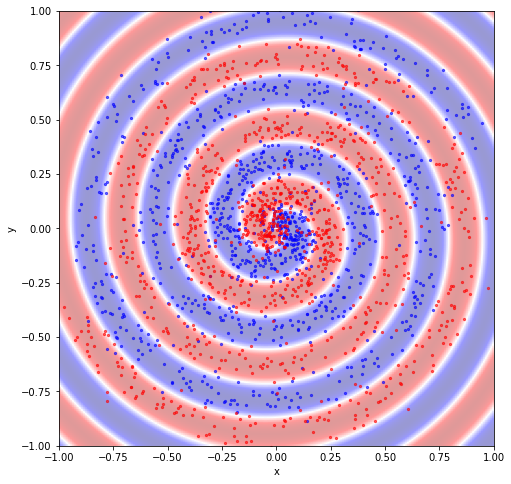

In [ ]:
!pip install -q iminuit 
from iminuit import Minuit

class CustomModel:
  """Classifier based on explicit modelling of the pdfs"""
  
  def fit(self, X, y):
    self.X = X
    self.y = y
    self.minuit = Minuit(self.loss, f=20, sigma=1, phi0=0, phi1=1)
    self.minuit.errordef = 0.5
    self.minuit.simplex().migrad()

    del self.X
    del self.y

    return self

  def custom_pdf (self, xy, f=20, phi=0, sigma=0.4):
    theta = np.arctan2(xy[:,0], xy[:,1])
    t = np.linalg.norm(xy, axis=1)

    phi_hat = theta - f * t
    return np.exp(-((phi_hat - phi + np.pi)%(2*np.pi) - np.pi)**2/(2*sigma**2))/(np.sqrt(2*np.pi*sigma**2))

  def predict_proba (self, X):
    return self.decision_function(X, *self.minuit.values)

  def decision_function (self, X, f=20, sigma=0.5, phi0=0, phi1=np.pi):
    pdf0 = self.custom_pdf(X, f=f, phi=phi0, sigma=sigma)
    pdf1 = self.custom_pdf(X, f=f, phi=phi1, sigma=sigma)
    p0 = 1/(1+np.exp(-np.log(pdf0/pdf1)))
    return np.c_[p0, 1-p0]

  def loss (self, f=20, sigma=0.5, phi0=0, phi1=10):
    p0, p1 = self.decision_function(self.X, f, sigma, phi0, phi1).T
    return -( np.sum(np.log(p0[self.y==0])) + np.sum(np.log(p1[self.y==1])) )

my_model = CustomModel()
X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
my_model.fit(X, y)

plt.figure(figsize=(8,8))
make_plot(my_model)
my_model.minuit

Verifichiamo le *performance*, confrontandole a quelle di *neural network* e *bdt* al meglio delle ottimizzazioni svolte.

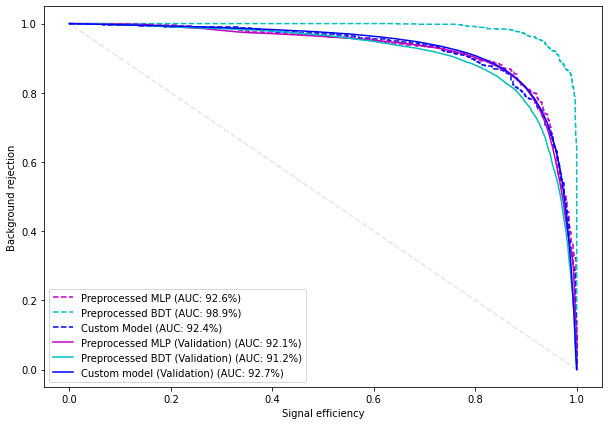

In [ ]:
plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, preprocessed_ann, "Preprocessed MLP", 'm--')
plot_roc(X, c, preprocessed_bdt, "Preprocessed BDT", 'c--')
plot_roc(X, c, my_model, "Custom Model", 'b--')


X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

# Validation sample
vx0, vy0, vx1, vy1 = generate_dataset(n0=100000, n1=100000)
vX = np.concatenate((np.c_[vx0,vy0], np.c_[vx1,vy1]))
vc = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

plot_roc(vX, vc, preprocessed_ann, "Preprocessed MLP (Validation)", 'm-')
plot_roc(vX, vc, preprocessed_bdt, "Preprocessed BDT (Validation)", 'c-')
plot_roc(vX, vc, my_model, "Custom model (Validation)", 'b-')

plt.legend(loc='lower left')

plt.show()

Osserviamo un leggero ma significativo miglioramento della performance di classificazione sul campione di validazione. Inoltre la performance ottenuta sul campione di training e quello di validazione sono estremamente simili, mostrando che l'algoritmo generalizza decisamente bene a campioni diversi ma statisticamente equivalenti. 

# Conclusioni

In questo *notebook* abbiamo affrontato un problema molto generale nel *machine learning* che riguarda la costruzione di modelli avanzati analizzandone le implicazioni in particolare nel task di classificazione. 
Abbiamo visto come l'abilità di un algoritmo di classificare gli elementi in un dataset dipende sostanzialmente dalle ipotesi che l'algoritmo può fare sulle distribuzioni generatrici del dataset stesso. 

Algoritmi avanzati, come Boosted Decision Tree e reti neurali artificiali, possono modificare la rappresentazione dei dati in modo da *imparare* autonomamente quali sono le trasformazioni che meglio si adattano a risolvere il problema affrontato. Tuttavia, in assenza di ipotesi su quali caratteristiche del dataset siano verosimili, l'unico criterio che può usare un algoritmo è di natura statistica. Ma questo implica la necessità di campioni molto grandi. 
Per studiare campioni più piccoli, dobbiamo iniettare informazione del sistema, cioè dobbiamo aggiungere assunzioni che siano basate sulla nostra esperienza del mondo ed in particolare del dataset che stiamo studiando. 

In ogni caso, una volta addestrato un algoritmo è sempre importante validarne le performance su un campione di dati non utilizzato in fase di addestramento, ma statisticamente equivalente. Se la performance sul campione usato in fase di validazione è troppo inferiore a quella ottenuta in fase di addestramento, significa che il nostro algoritmo sta prendendo fluttuazioni statistiche del dataset per strutture generali della pdf generatrice del dataset, perdendo la capacità di generalizzare. Questo fenomeno, chiamato *over-training*, rende poco affidabili gli algoritmi e si cerca di limitarlo. 

Per limitare il fenomeno dell'over-training dobbiamo aggiungere informazione o ipotesi al dataset studiato, il che può essere ottenuto in tre modi:
 * aumentando la statistica del campione di addestramento
 * semplificando il modello
 * regolarizzando il modello 

Le tecniche di regolarizzazione differiscono da algoritmo ad algoritmo e in generale cercano di limitare la sensibilità di algoritmi avanzati a strutture di pochi eventi. Abbiamo visto ad esempio il caso del BDT in cui una tecnica di regolarizzazione ampiamente utilizzata consiste nel richiedere che le foglie di ciascun albero decisionale non contengano mai meno di un certo numero di entries. 

Abbiamo concluso il *notebook* ricordando che, interpretando in modo lasco il Lemma di Neyman-Pearson, il classificatore più potente si ottiene mappando opportunamente il rapporto delle likelihood delle due classi tra 0 e 1 e interpretandolo come probabilità di appartenere ad una classe piuttosto di un'altra. Quando questo è possibile, è molto spesso conveniente perché le ipotesi sul dataset che stiamo iniettando nella soluzione del problema sono enormi. Nella realtà tuttavia, raramente si dispone di una forma analitica per le *pdf* delle componenti da classificare, specialmente quando le variabili sono molte. 

Tuttavia, anche se non abbiamo una forma esplicita delle *pdf* possiamo preprocessare i dati per rendere più evidente e più "facile" per la rete identificare le strutture che ci aspettiamo siano significative anche nelle *pdf* generatrici. Abbiamo visto l'esempio della trasformazione in coordinate polari.